# Girvan-Newman Community Detection Algorithm

This notebook demonstrates the Girvan-Newman algorithm, a divisive hierarchical method for community detection in networks.

## 1. Theory and Background

The Girvan-Newman algorithm is a **divisive hierarchical clustering method** for detecting communities in complex networks. Unlike agglomerative methods that build communities from the bottom up, Girvan-Newman works from the top down by progressively removing edges to break the network into increasingly smaller components.

### Key Concepts

- **Edge Betweenness**: The number of shortest paths between pairs of nodes that pass through an edge.
- **Bridges**: Edges with high betweenness are likely to connect different communities.
- **Divisive Approach**: Systematically removing edges to reveal the community structure.

### Algorithm Steps:

1. Calculate betweenness for all edges in the network
2. Remove the edge with the highest betweenness
3. Recalculate betweenness for all remaining edges
4. Repeat steps 2-3 until no edges remain

The algorithm produces a dendrogram showing the hierarchical structure of communities in the network.

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import random
from itertools import islice
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

## 2. Zachary's Karate Club Network

We'll use Zachary's Karate Club network, a classic dataset in network science. This network represents friendships between 34 members of a karate club at a US university in the 1970s. The club split into two groups following a dispute between the instructor (node 0) and the administrator (node 33).

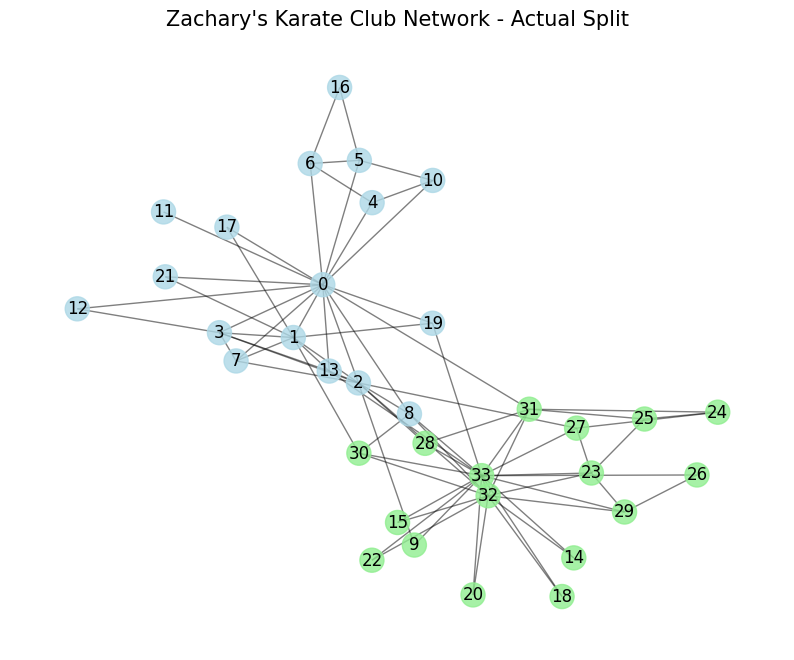

Number of nodes: 34
Number of edges: 78


In [2]:
# Load Zachary's Karate Club network
G = nx.karate_club_graph()

# Get the actual club split (ground truth)
club_colors = ['lightblue' if G.nodes[node]['club'] == 'Mr. Hi' else 'lightgreen' for node in G.nodes()]

# Visualize the network with actual club memberships
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)  # Position nodes using a spring layout
nx.draw_networkx_nodes(G, pos, node_color=club_colors, node_size=300, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=12)
plt.title("Zachary's Karate Club Network - Actual Split", fontsize=15)
plt.axis('off')
plt.show()

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

## 3. Implementation of Girvan-Newman Algorithm from Scratch

Let's implement the Girvan-Newman algorithm from scratch to better understand how it works. We'll go through each step in detail:

1. Calculate the betweenness of all edges in the network
2. Remove the edge with the highest betweenness
3. Recalculate the betweenness for all remaining edges
4. Repeat steps 2-3 until no edges remain or the desired number of communities is reached

This implementation will help visualize how communities evolve as edges are removed.

In [3]:
# We'll use NetworkX's implementation instead of creating our own
def calculate_edge_betweenness(G):
    """
    Use NetworkX's built-in edge betweenness centrality function
    
    Args:
        G: A NetworkX graph
        
    Returns:
        A dictionary mapping edge tuples (u, v) to their betweenness values
    """
    return nx.edge_betweenness_centrality(G)

In [4]:
def girvan_newman_step_by_step(G, max_iterations=None):
    """
    Implementation of Girvan-Newman community detection algorithm with step-by-step visualization.
    Uses NetworkX's edge betweenness centrality implementation.
    
    Args:
        G: A NetworkX graph
        max_iterations: Maximum number of edge removals to perform (optional)
        
    Returns:
        A list of community structures at each step of the algorithm
    """
    # Make a copy of the graph to avoid modifying the original
    working_graph = G.copy()
    
    # Keep track of communities at each step
    community_history = []
    
    # Loop until graph is empty or max_iterations is reached
    iteration = 0
    
    while working_graph.edges() and (max_iterations is None or iteration < max_iterations):
        # Calculate edge betweenness using NetworkX's implementation
        edge_betweenness = nx.edge_betweenness_centrality(working_graph)
        
        # Find edge with highest betweenness
        max_betweenness = -1
        edge_to_remove = None
        
        for edge, betweenness in edge_betweenness.items():
            if betweenness > max_betweenness:
                max_betweenness = betweenness
                edge_to_remove = edge
        
        # Remove edge with highest betweenness
        working_graph.remove_edge(*edge_to_remove)
        
        # Find connected components (communities)
        communities = [set(c) for c in nx.connected_components(working_graph)]
        community_history.append((communities, edge_to_remove, max_betweenness))
        
        iteration += 1
    
    return community_history

In [5]:
def visualize_gn_steps(G, community_history, num_steps=5, pos=None):
    """
    Visualize steps of the Girvan-Newman algorithm.
    
    Args:
        G: Original NetworkX graph
        community_history: History of communities from girvan_newman_step_by_step
        num_steps: Number of steps to visualize
        pos: Node positions for consistent layout (optional)
    """
    if pos is None:
        pos = nx.spring_layout(G, seed=42)
    
    steps_to_show = min(num_steps, len(community_history))
    
    for i in range(steps_to_show):
        communities, edge_removed, betweenness = community_history[i]
        
        plt.figure(figsize=(10, 8))
        
        # Create working graph with all edges removed up to this point
        working_G = G.copy()
        for j in range(i+1):
            working_G.remove_edge(*community_history[j][1])
        
        # Assign colors to communities with a light color palette
        colors = cm.Pastel1(np.linspace(0, 1, len(communities)))
        node_colors = {}
        for idx, community in enumerate(communities):
            for node in community:
                node_colors[node] = colors[idx]
        
        #
        nx.draw_networkx_nodes(G, pos, node_color=[node_colors[node] for node in G.nodes()],
                              node_size=300, alpha=0.8, 
                              edgecolors='black')
        
        # Draw remaining edges
        nx.draw_networkx_edges(working_G, pos, width=1.0, alpha=0.5)
        
        # Highlight the removed edge in this step
        nx.draw_networkx_edges(G, pos, edgelist=[edge_removed],
                              width=2.5, alpha=1.0, edge_color='red', style='dashed')
        
        # Draw node labels
        nx.draw_networkx_labels(G, pos, font_size=11)
        
        plt.title(f"Step {i+1}: Removed edge {edge_removed} with betweenness {betweenness:.4f}\n"
                 f"Resulting in {len(communities)} communities", fontsize=15)
        plt.axis('off')
        plt.show()
        
        print(f"Step {i+1}: Removed edge {edge_removed} with betweenness {betweenness:.4f}")
        print(f"Number of communities: {len(communities)}")
        print(f"Community sizes: {[len(c) for c in communities]}")
        print("-" * 50)

### Running the Algorithm on Zachary's Karate Club

Now let's apply our implementation to Zachary's Karate Club network and visualize the first few steps of the algorithm to understand how communities are gradually revealed.

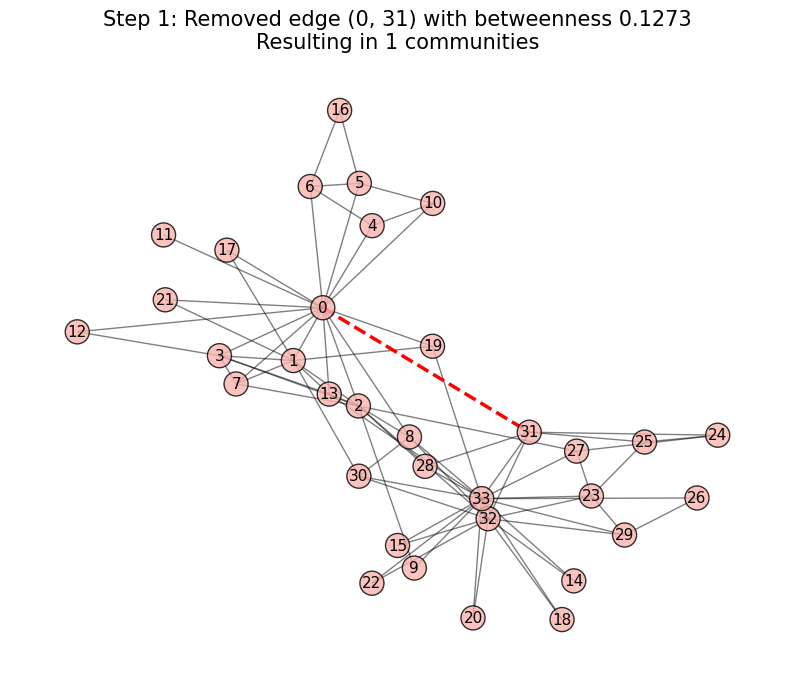

Step 1: Removed edge (0, 31) with betweenness 0.1273
Number of communities: 1
Community sizes: [34]
--------------------------------------------------


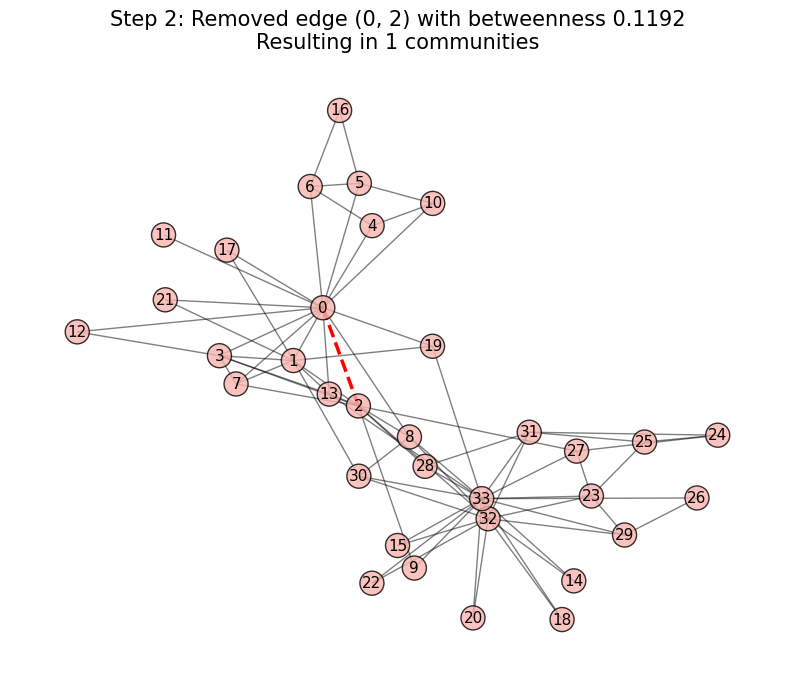

Step 2: Removed edge (0, 2) with betweenness 0.1192
Number of communities: 1
Community sizes: [34]
--------------------------------------------------


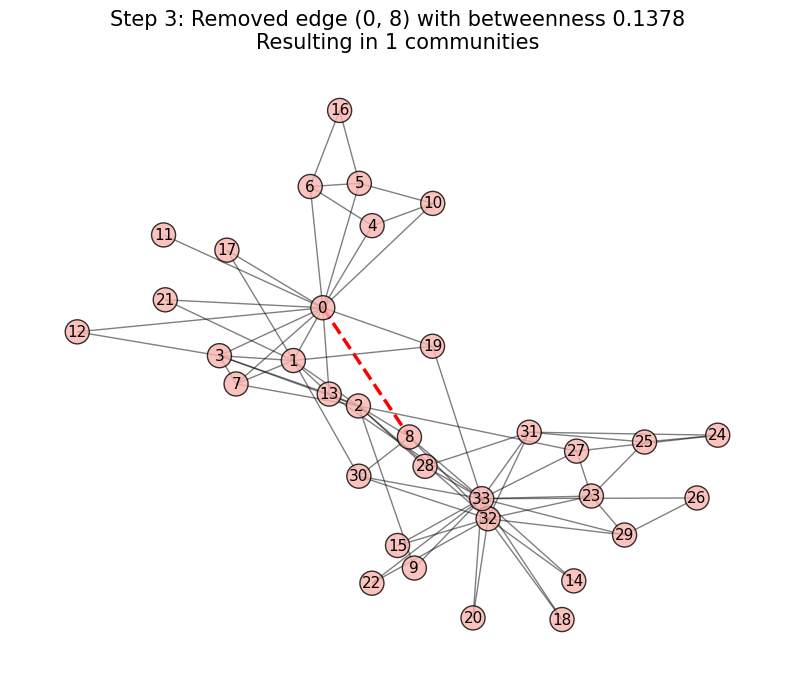

Step 3: Removed edge (0, 8) with betweenness 0.1378
Number of communities: 1
Community sizes: [34]
--------------------------------------------------


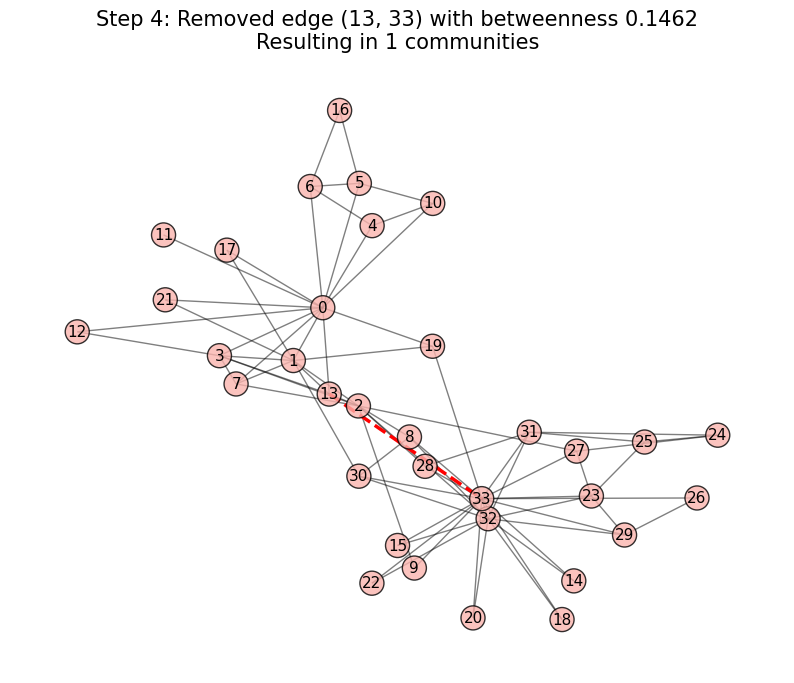

Step 4: Removed edge (13, 33) with betweenness 0.1462
Number of communities: 1
Community sizes: [34]
--------------------------------------------------


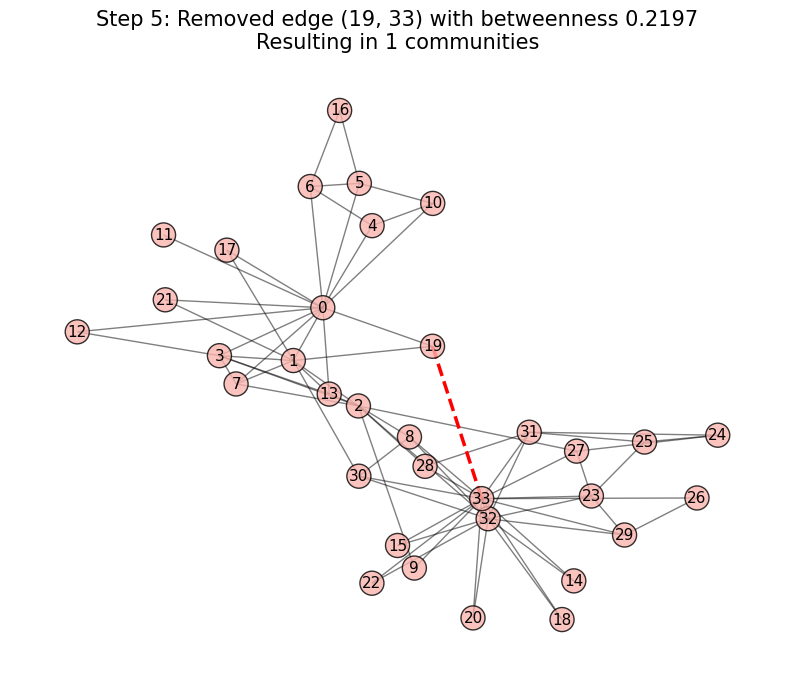

Step 5: Removed edge (19, 33) with betweenness 0.2197
Number of communities: 1
Community sizes: [34]
--------------------------------------------------


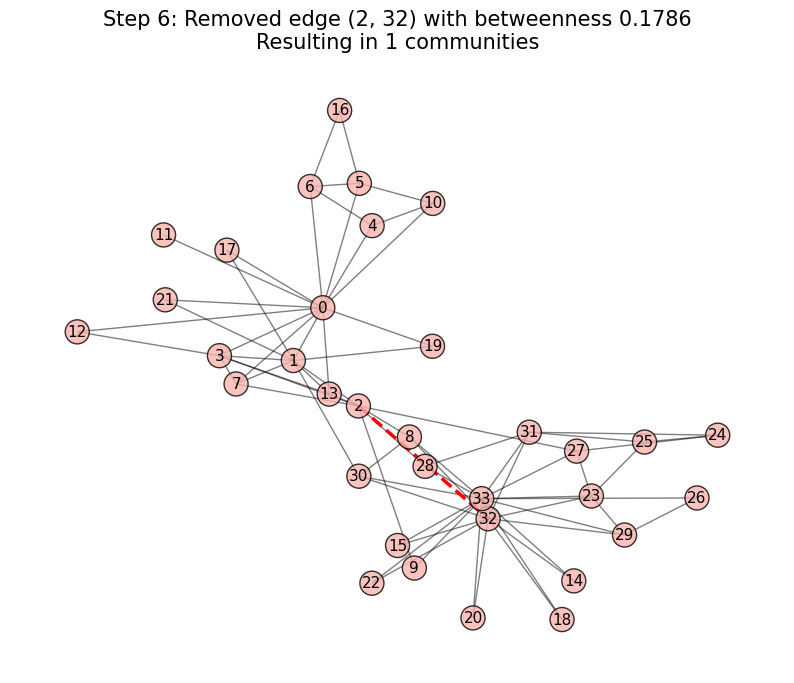

Step 6: Removed edge (2, 32) with betweenness 0.1786
Number of communities: 1
Community sizes: [34]
--------------------------------------------------


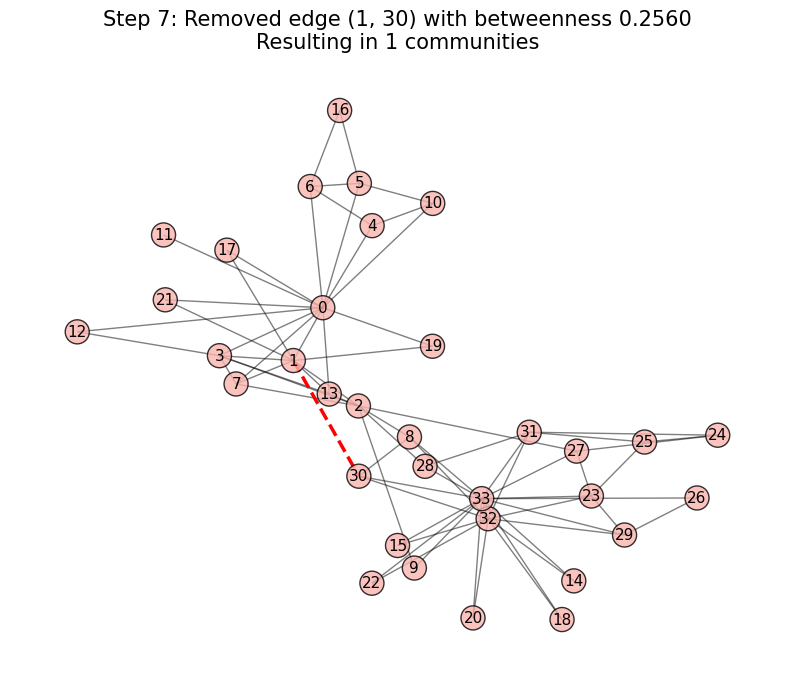

Step 7: Removed edge (1, 30) with betweenness 0.2560
Number of communities: 1
Community sizes: [34]
--------------------------------------------------


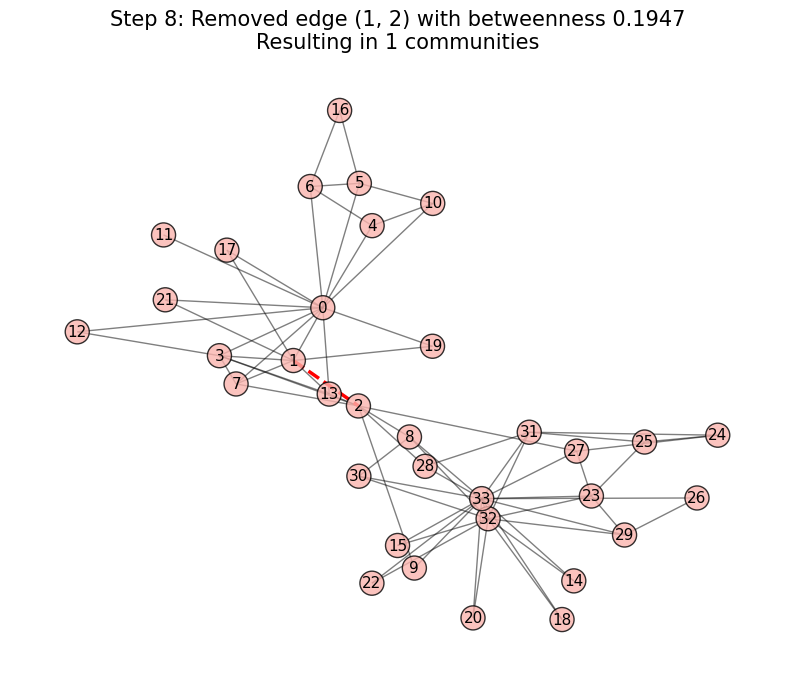

Step 8: Removed edge (1, 2) with betweenness 0.1947
Number of communities: 1
Community sizes: [34]
--------------------------------------------------


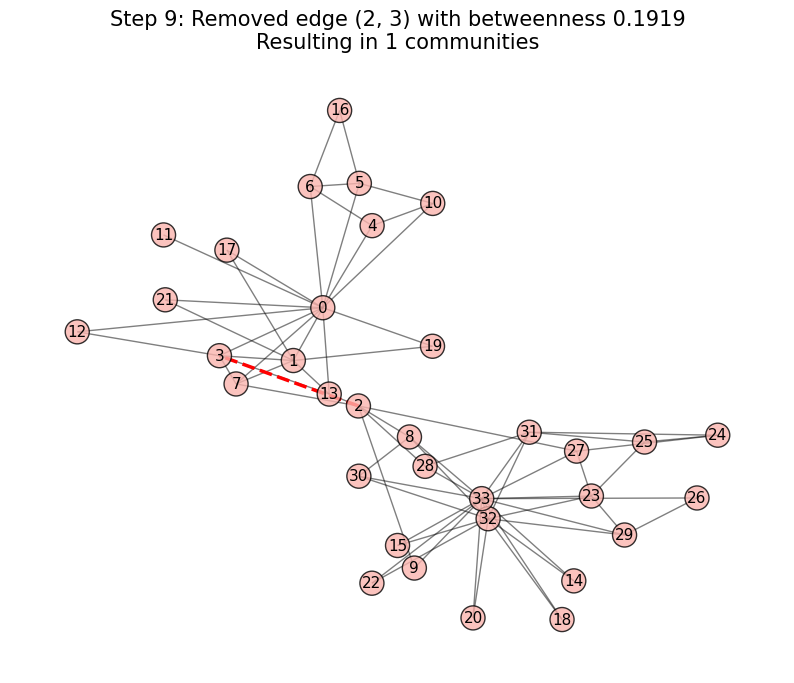

Step 9: Removed edge (2, 3) with betweenness 0.1919
Number of communities: 1
Community sizes: [34]
--------------------------------------------------


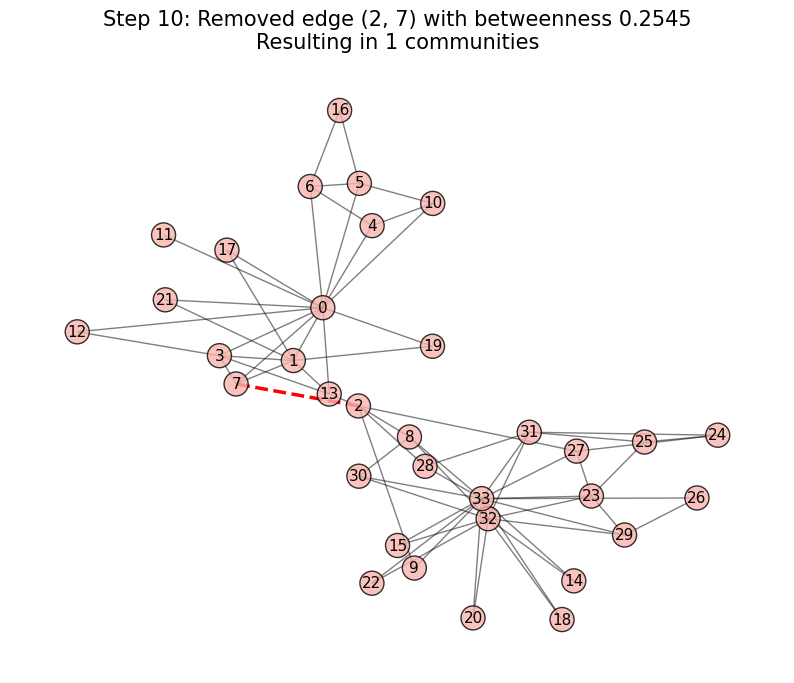

Step 10: Removed edge (2, 7) with betweenness 0.2545
Number of communities: 1
Community sizes: [34]
--------------------------------------------------


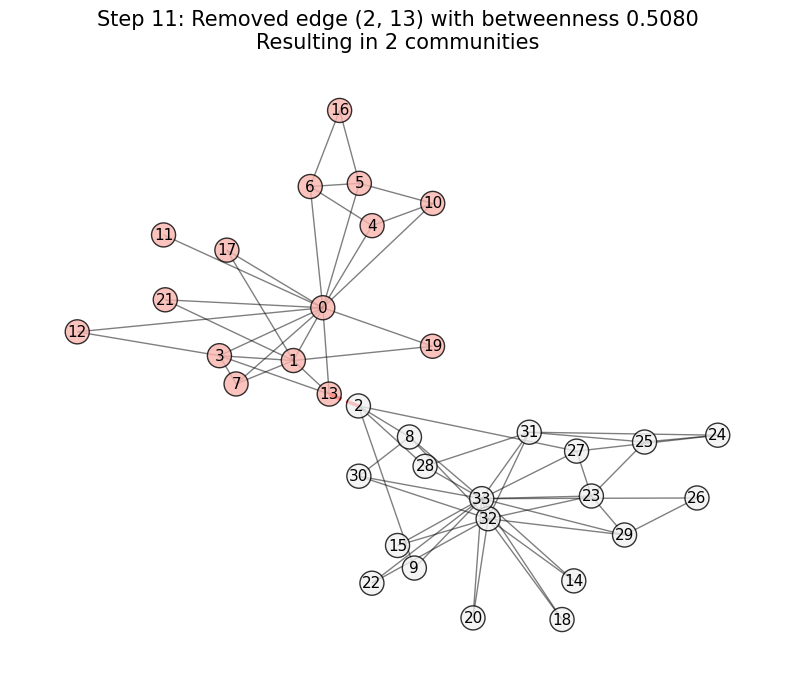

Step 11: Removed edge (2, 13) with betweenness 0.5080
Number of communities: 2
Community sizes: [15, 19]
--------------------------------------------------


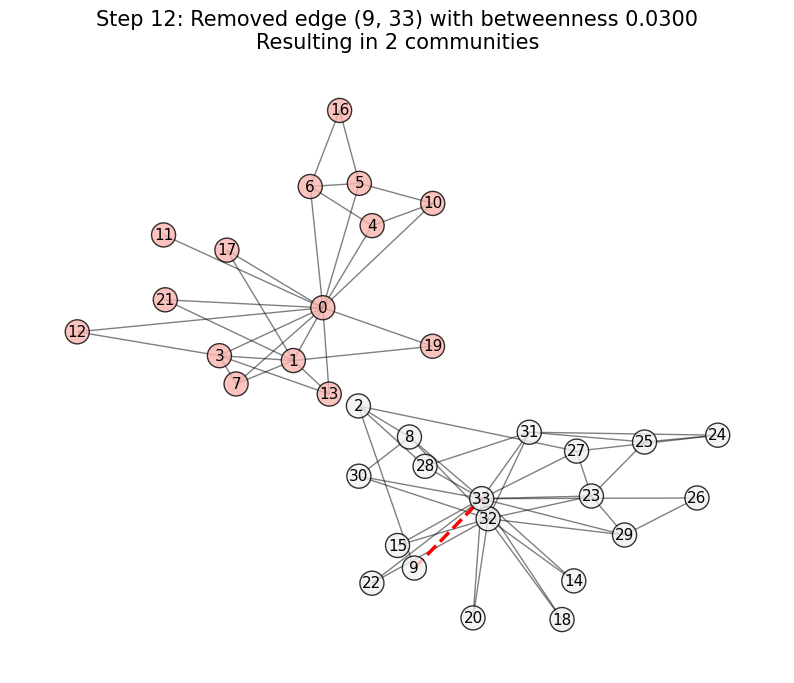

Step 12: Removed edge (9, 33) with betweenness 0.0300
Number of communities: 2
Community sizes: [15, 19]
--------------------------------------------------


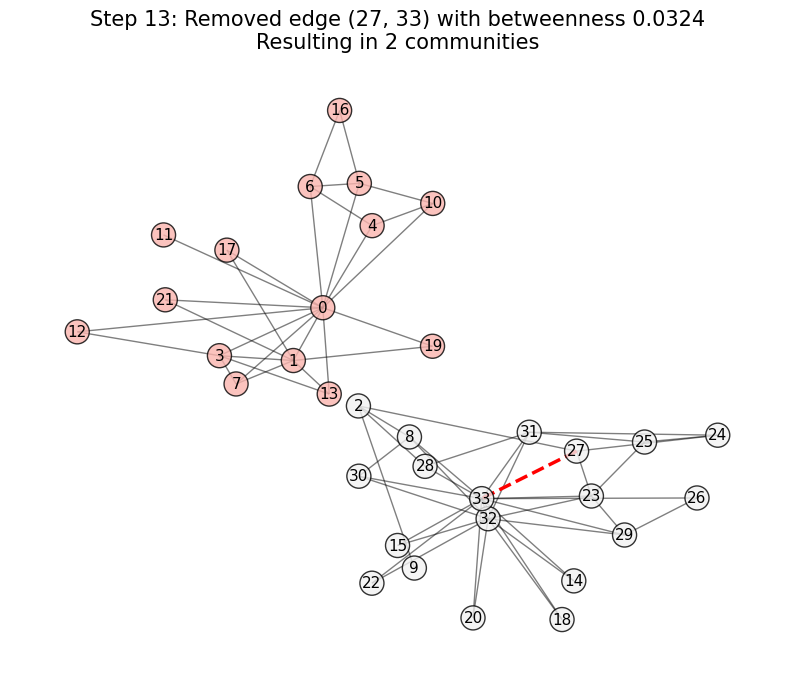

Step 13: Removed edge (27, 33) with betweenness 0.0324
Number of communities: 2
Community sizes: [15, 19]
--------------------------------------------------


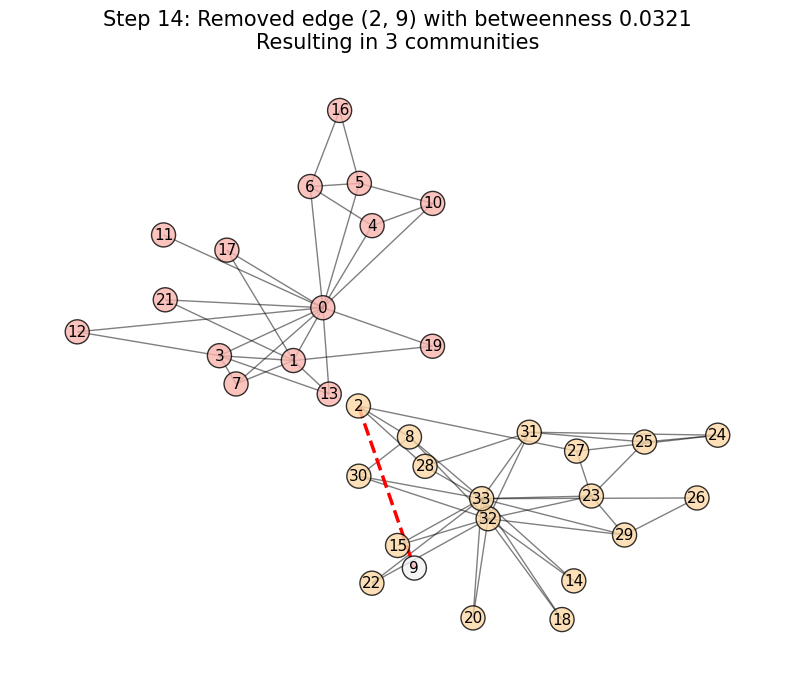

Step 14: Removed edge (2, 9) with betweenness 0.0321
Number of communities: 3
Community sizes: [15, 18, 1]
--------------------------------------------------


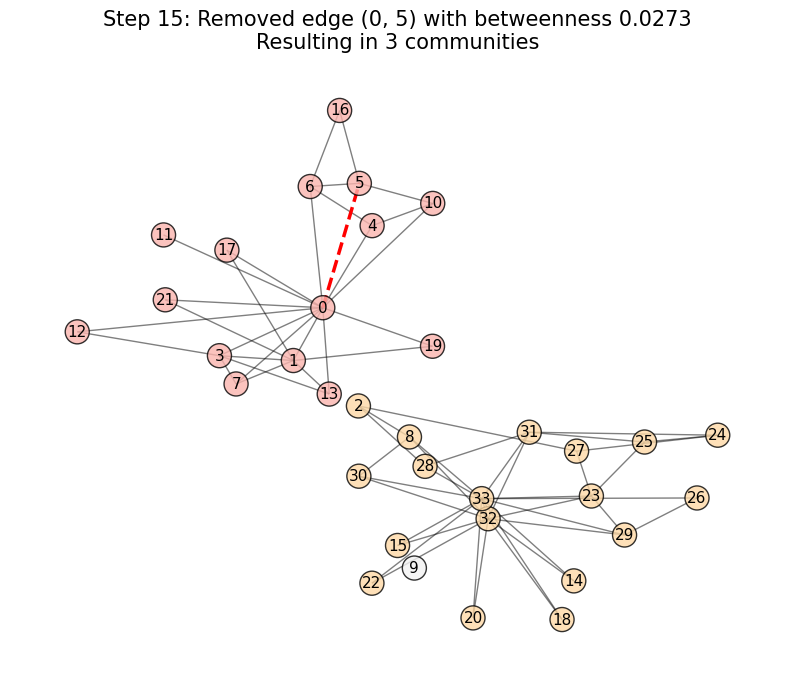

Step 15: Removed edge (0, 5) with betweenness 0.0273
Number of communities: 3
Community sizes: [15, 18, 1]
--------------------------------------------------


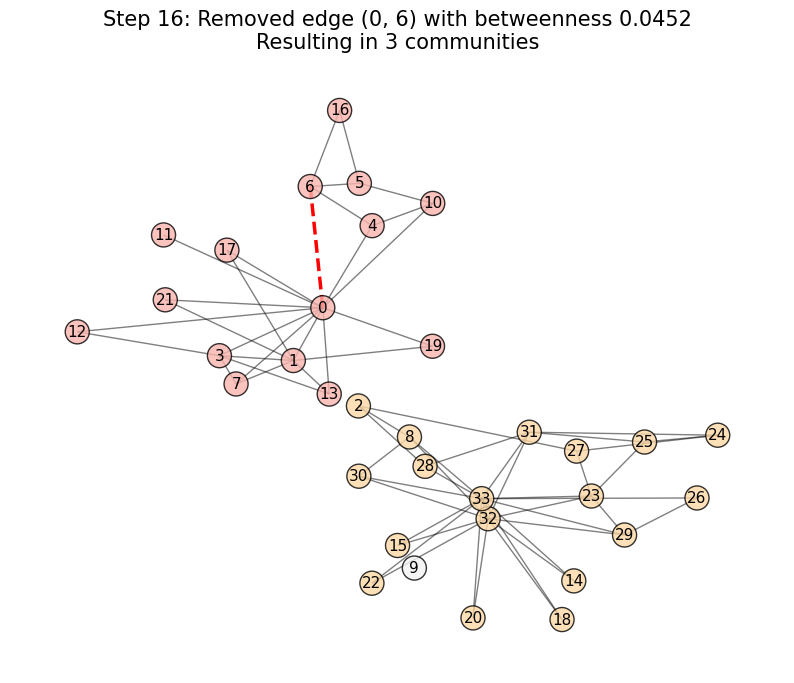

Step 16: Removed edge (0, 6) with betweenness 0.0452
Number of communities: 3
Community sizes: [15, 18, 1]
--------------------------------------------------


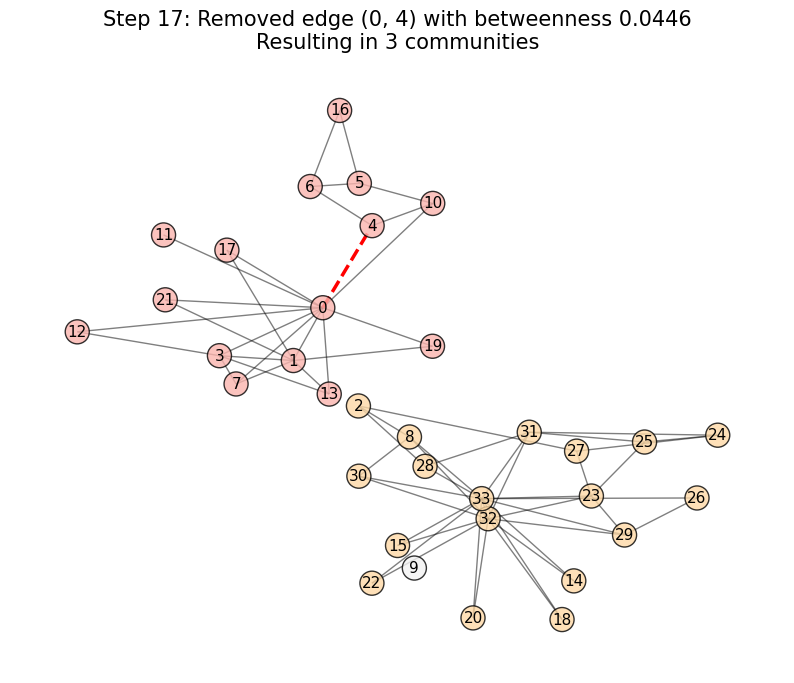

Step 17: Removed edge (0, 4) with betweenness 0.0446
Number of communities: 3
Community sizes: [15, 18, 1]
--------------------------------------------------


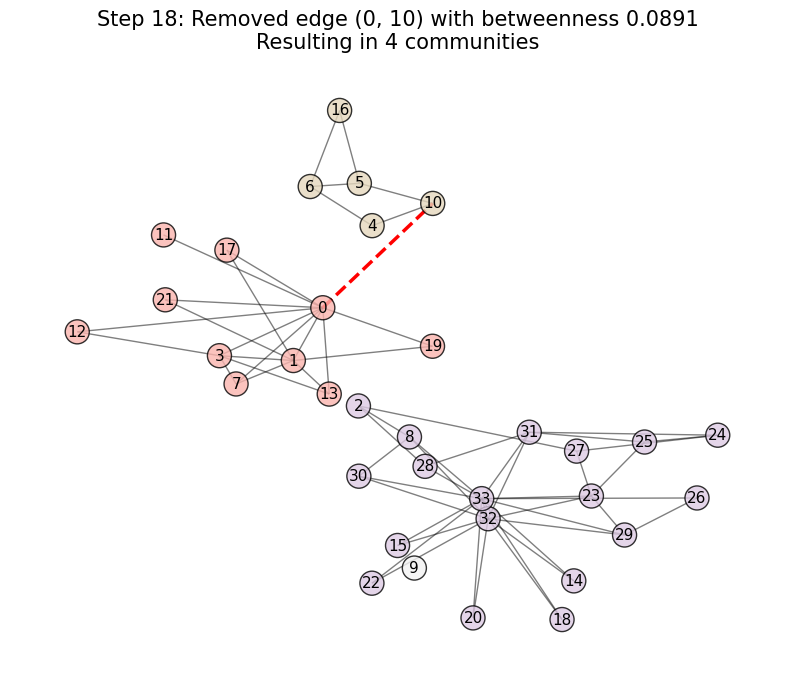

Step 18: Removed edge (0, 10) with betweenness 0.0891
Number of communities: 4
Community sizes: [10, 18, 5, 1]
--------------------------------------------------


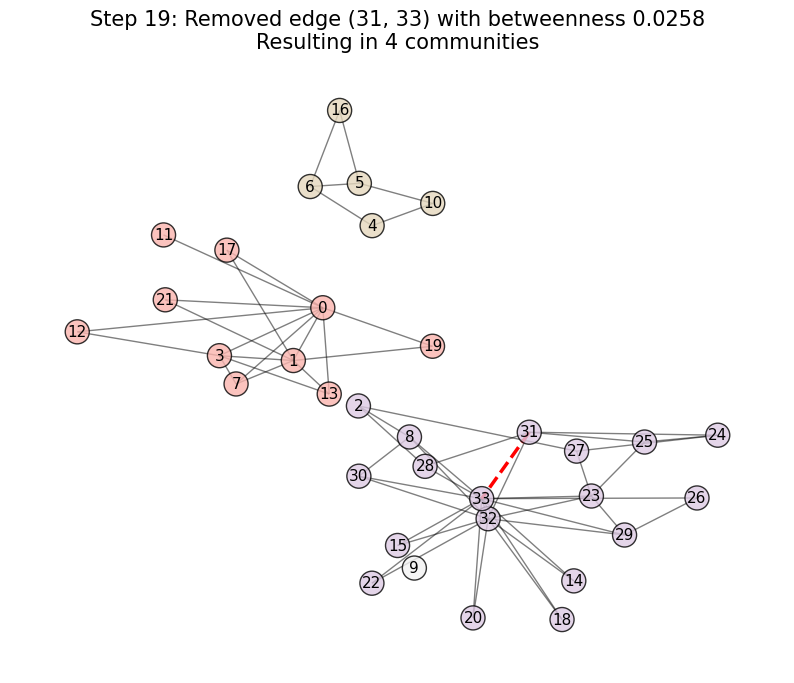

Step 19: Removed edge (31, 33) with betweenness 0.0258
Number of communities: 4
Community sizes: [10, 18, 5, 1]
--------------------------------------------------


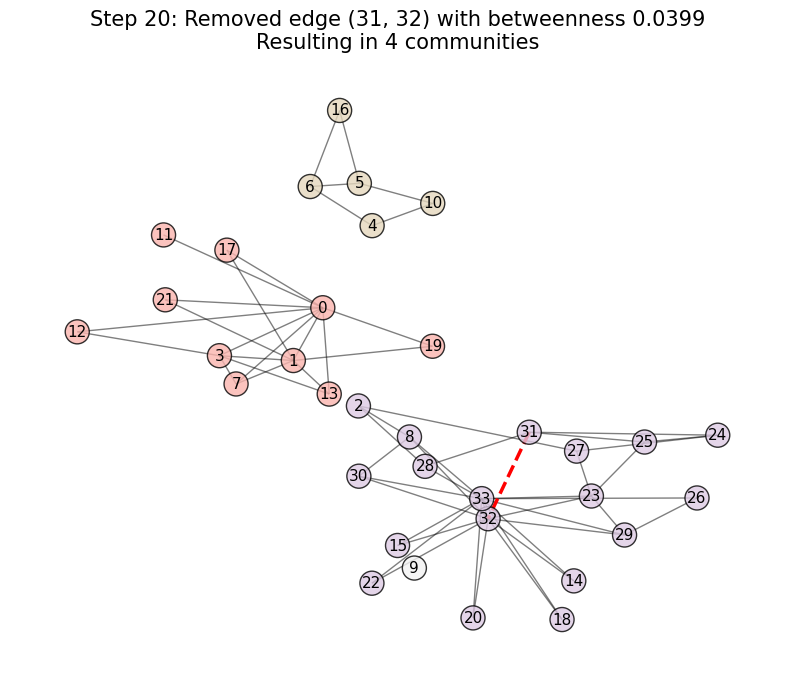

Step 20: Removed edge (31, 32) with betweenness 0.0399
Number of communities: 4
Community sizes: [10, 18, 5, 1]
--------------------------------------------------


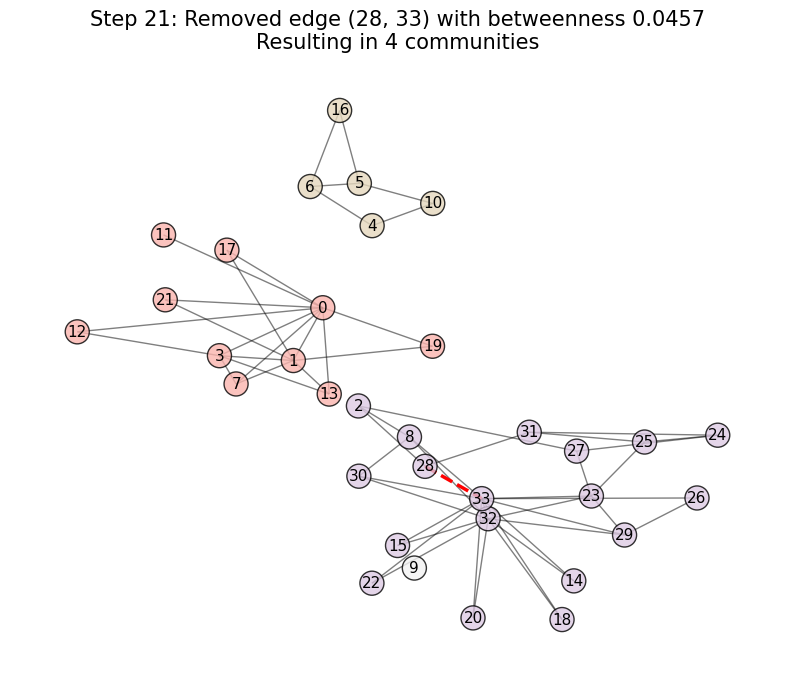

Step 21: Removed edge (28, 33) with betweenness 0.0457
Number of communities: 4
Community sizes: [10, 18, 5, 1]
--------------------------------------------------


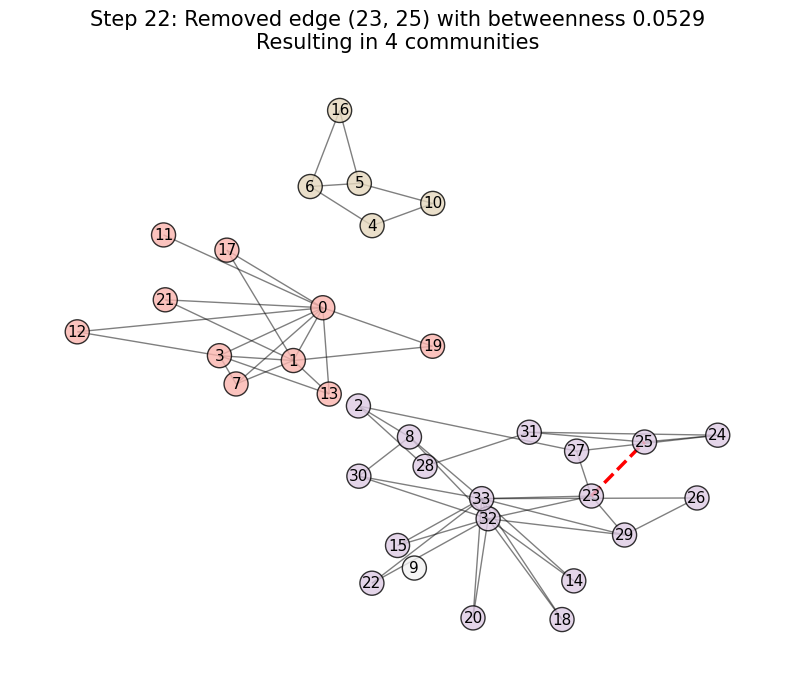

Step 22: Removed edge (23, 25) with betweenness 0.0529
Number of communities: 4
Community sizes: [10, 18, 5, 1]
--------------------------------------------------


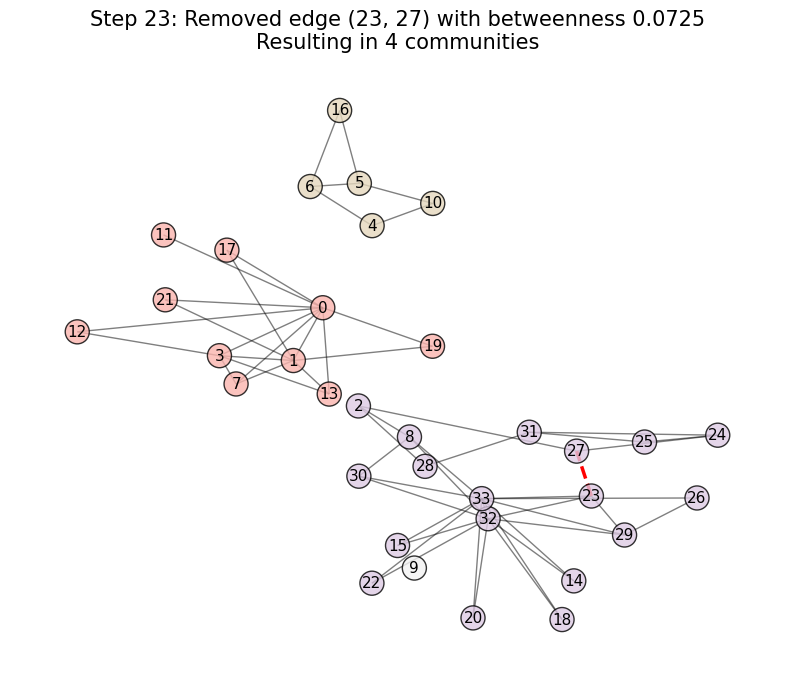

Step 23: Removed edge (23, 27) with betweenness 0.0725
Number of communities: 4
Community sizes: [10, 18, 5, 1]
--------------------------------------------------


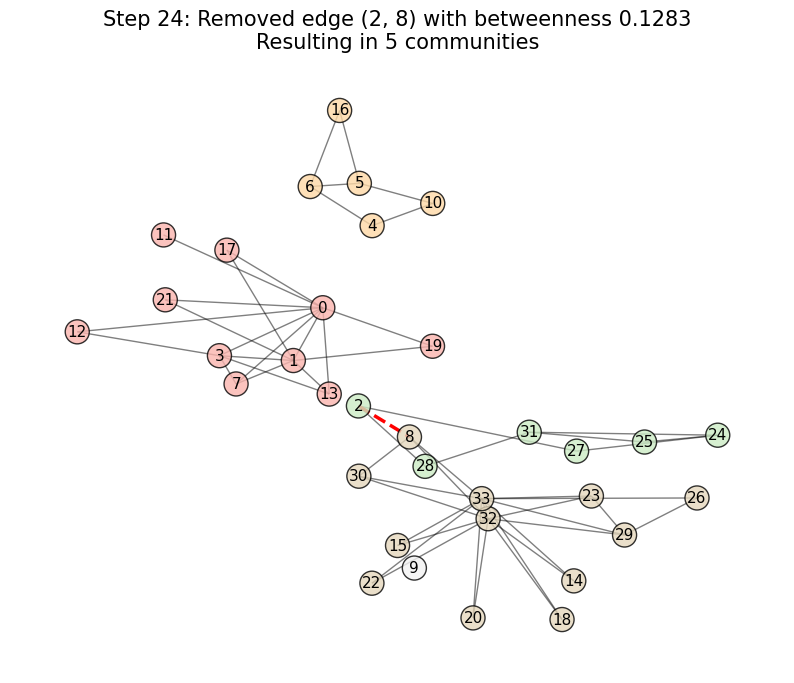

Step 24: Removed edge (2, 8) with betweenness 0.1283
Number of communities: 5
Community sizes: [10, 6, 5, 12, 1]
--------------------------------------------------


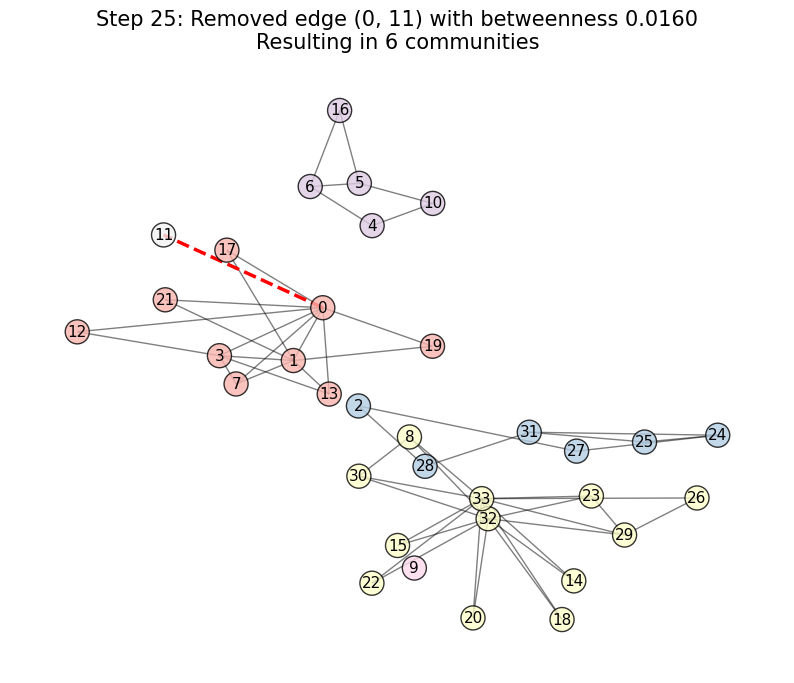

Step 25: Removed edge (0, 11) with betweenness 0.0160
Number of communities: 6
Community sizes: [9, 6, 5, 12, 1, 1]
--------------------------------------------------


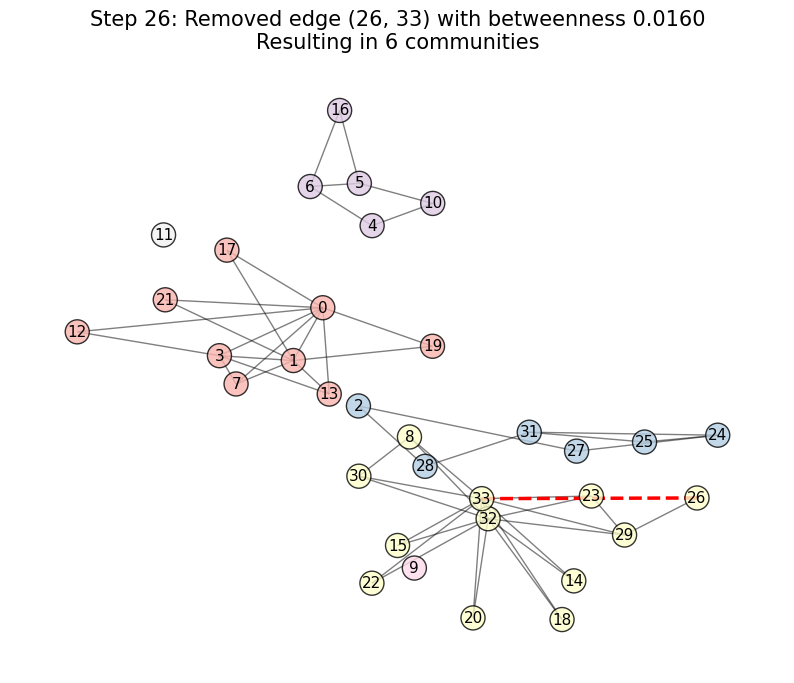

Step 26: Removed edge (26, 33) with betweenness 0.0160
Number of communities: 6
Community sizes: [9, 6, 5, 12, 1, 1]
--------------------------------------------------


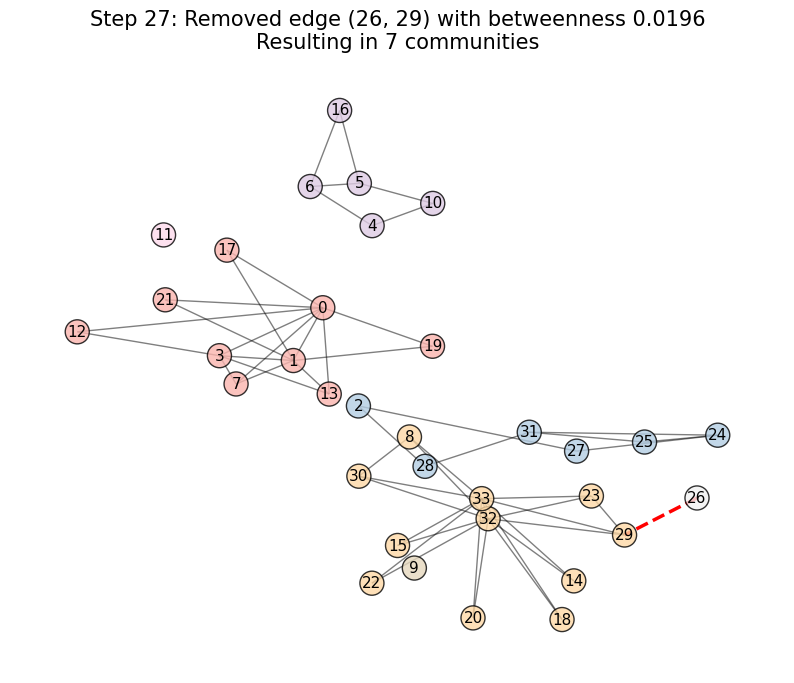

Step 27: Removed edge (26, 29) with betweenness 0.0196
Number of communities: 7
Community sizes: [9, 6, 5, 11, 1, 1, 1]
--------------------------------------------------


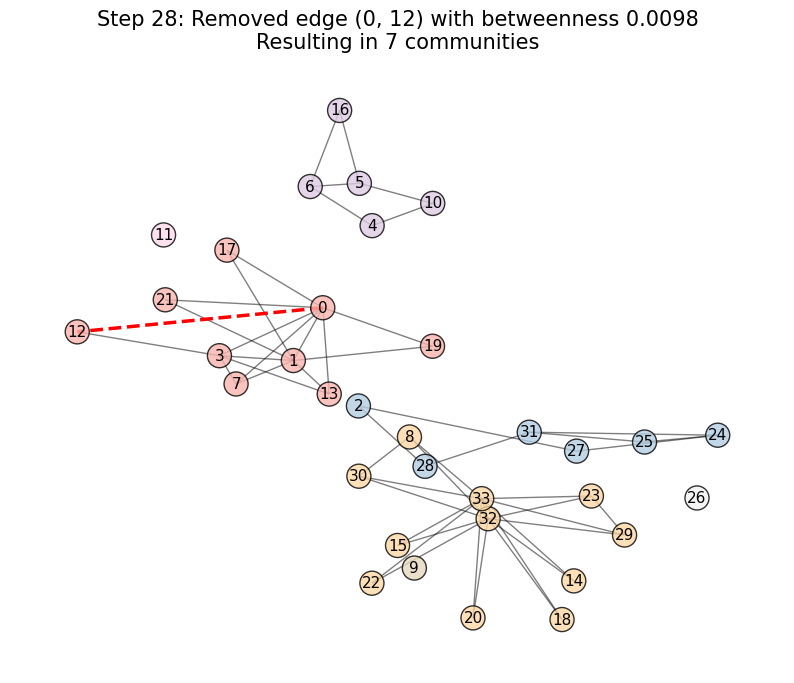

Step 28: Removed edge (0, 12) with betweenness 0.0098
Number of communities: 7
Community sizes: [9, 6, 5, 11, 1, 1, 1]
--------------------------------------------------


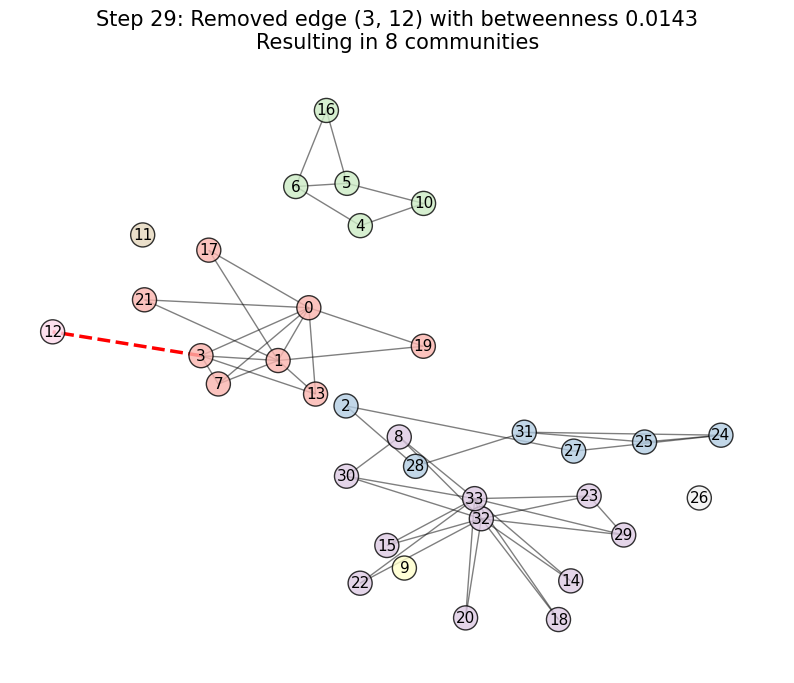

Step 29: Removed edge (3, 12) with betweenness 0.0143
Number of communities: 8
Community sizes: [8, 6, 5, 11, 1, 1, 1, 1]
--------------------------------------------------


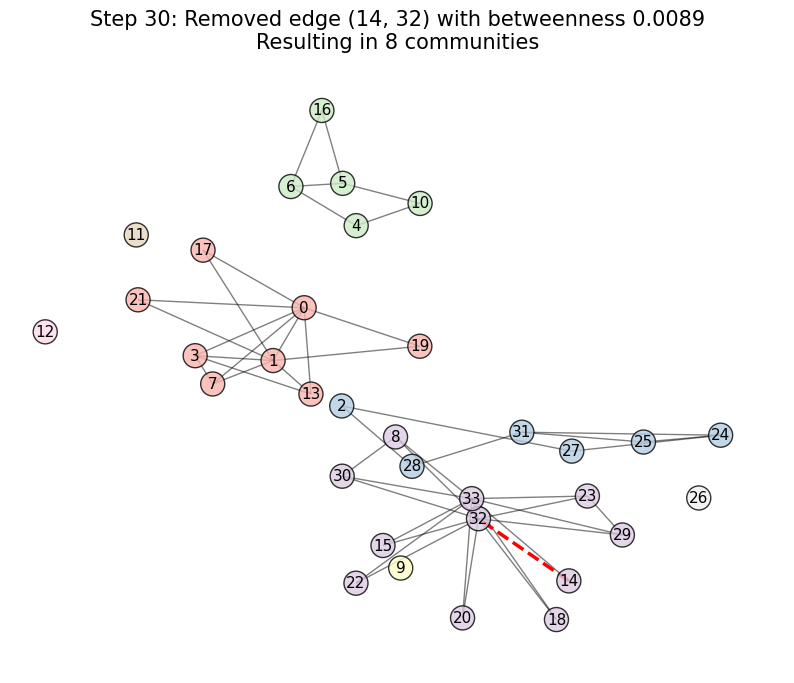

Step 30: Removed edge (14, 32) with betweenness 0.0089
Number of communities: 8
Community sizes: [8, 6, 5, 11, 1, 1, 1, 1]
--------------------------------------------------


In [6]:
# Apply our implementation to Zachary's Karate Club
# For instructional purposes, we'll limit to 10 iterations
community_history = girvan_newman_step_by_step(G, max_iterations=100)

# Visualize the first 5 steps
visualize_gn_steps(G, community_history, num_steps=30)

### Validating Our Implementation

Let's compare the edge betweenness calculated by our implementation with NetworkX's built-in function to ensure our implementation is correct.

In [7]:
# Calculate edge betweenness using NetworkX's implementation
our_betweenness = nx.edge_betweenness_centrality(G)

# Calculate edge betweenness using NetworkX again for comparison
nx_betweenness = nx.edge_betweenness_centrality(G)

# Compare the top 5 edges from both calculations
our_top5 = sorted(our_betweenness.items(), key=lambda x: x[1], reverse=True)[:5]
nx_top5 = sorted(nx_betweenness.items(), key=lambda x: x[1], reverse=True)[:5]

# Create DataFrame for comparison
comparison = pd.DataFrame({
    'Edge': [f"{e[0]}-{e[1]}" for e, _ in our_top5],
    'Our Implementation': [b for _, b in our_top5],
    'NetworkX Implementation': [nx_betweenness[e] for e, _ in our_top5]
})

print("Top 5 Edges by Betweenness - Comparison:")
comparison

Top 5 Edges by Betweenness - Comparison:


Edge  Our Implementation  NetworkX Implementation
0  0-31            0.127260                 0.127260
1   0-6            0.078134                 0.078134
2   0-5            0.078134                 0.078134
3   0-2            0.077788                 0.077788
4   0-8            0.074240                 0.074240

### Implementing Modularity Calculation from Scratch

Modularity is a key metric for evaluating the quality of community detection. Let's implement it from scratch to better understand how it works.

In [8]:
def calculate_modularity(G, communities):
    """
    Calculate modularity for a given network partition.
    
    Modularity measures the strength of division into communities by comparing
    the density of connections inside communities with the density of connections
    between communities.
    """
    # Use NetworkX's built-in modularity function
    return nx.community.quality.modularity(G, communities)

Step 1: 1 communities, Modularity: 0.0000
Step 2: 1 communities, Modularity: 0.0000
Step 3: 1 communities, Modularity: 0.0000
Step 4: 1 communities, Modularity: 0.0000
Step 5: 1 communities, Modularity: 0.0000
Step 6: 1 communities, Modularity: 0.0000
Step 7: 1 communities, Modularity: 0.0000
Step 8: 1 communities, Modularity: 0.0000
Step 9: 1 communities, Modularity: 0.0000
Step 10: 1 communities, Modularity: 0.0000
Step 11: 2 communities, Modularity: 0.3477
Step 12: 2 communities, Modularity: 0.3477
Step 13: 2 communities, Modularity: 0.3477
Step 14: 3 communities, Modularity: 0.3423
Step 15: 3 communities, Modularity: 0.3423
Step 16: 3 communities, Modularity: 0.3423
Step 17: 3 communities, Modularity: 0.3423
Step 18: 4 communities, Modularity: 0.3581
Step 19: 4 communities, Modularity: 0.3581
Step 20: 4 communities, Modularity: 0.3581
Step 21: 4 communities, Modularity: 0.3581
Step 22: 4 communities, Modularity: 0.3581
Step 23: 4 communities, Modularity: 0.3581
Step 24: 5 communiti

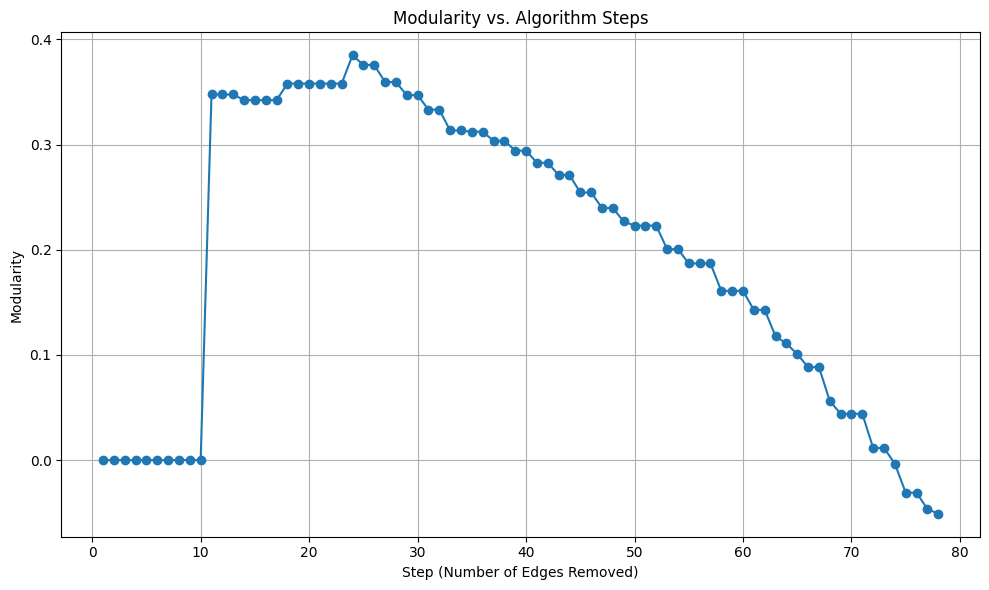


Maximum modularity 0.3850 at step 24 with 5 communities


In [11]:
# Track modularity through the algorithm steps
modularities = []
community_counts = []

for i, (communities, edge, _) in enumerate(community_history):
    modularity = calculate_modularity(G, communities)
    modularities.append(modularity)
    community_counts.append(len(communities))
    
    print(f"Step {i+1}: {len(communities)} communities, Modularity: {modularity:.4f}")

# Plot modularity progression
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(modularities)+1), modularities, 'o-')
plt.xlabel('Step (Number of Edges Removed)')
plt.ylabel('Modularity')
plt.title('Modularity vs. Algorithm Steps')
plt.grid(True)
plt.tight_layout()
plt.show()

# Find the optimal step (maximum modularity)
best_step = np.argmax(modularities)
print(f"\nMaximum modularity {modularities[best_step]:.4f} at step {best_step+1} with {community_counts[best_step]} communities")

### Time Complexity Analysis

Let's measure the execution time of our implementation to understand the computational complexity of the algorithm.

In [10]:
import time

# Measure time for edge betweenness calculation using NetworkX
start_time = time.time()
_ = nx.edge_betweenness_centrality(G)
end_time = time.time()
print(f"Time to calculate edge betweenness once: {end_time - start_time:.4f} seconds")

# Estimate time for full algorithm run
n_edges = G.number_of_edges()
estimated_time = (end_time - start_time) * n_edges
print(f"Estimated time for full algorithm run: {estimated_time:.2f} seconds")
print(f"Using NetworkX's implementation is typically faster but still follows the O(m²n) complexity,")
print(f"as we need to calculate betweenness {n_edges} times.")

Time to calculate edge betweenness once: 0.0030 seconds
Estimated time for full algorithm run: 0.23 seconds
Using NetworkX's implementation is typically faster but still follows the O(m²n) complexity,
as we need to calculate betweenness 78 times.


### Key Takeaways from the Implementation

1. **Edge Betweenness Calculation**: We used NetworkX's efficient implementation of edge betweenness centrality, which is optimized and typically faster than a custom implementation.

2. **Progressive Community Formation**: As edges with high betweenness are removed, the network naturally splits into communities. The first few edge removals often make the most significant changes to the community structure.

3. **Modularity Optimization**: Modularity helps determine the optimal point to stop the algorithm, which is not necessarily when the network is completely disconnected.

4. **Computational Complexity**: Even with NetworkX's implementation, the algorithm's O(m²n) time complexity makes it unsuitable for very large networks without modifications or approximations.

5. **Deterministic Results**: Unlike some community detection algorithms that depend on random initialization, Girvan-Newman produces deterministic results for a given network.

By using NetworkX's efficient implementation, we've improved performance while still gaining insights into how the algorithm works at each step and the challenges involved in optimizing it for large networks.

## 4. Pros and Cons of the Girvan-Newman Algorithm

### Advantages

1. **Intuitive approach**: The algorithm is based on the intuitive idea that communities are connected by bridges, which have high betweenness.

2. **No need to specify the number of communities**: The algorithm naturally reveals the hierarchical structure of communities.

3. **Hierarchical structure**: Produces a dendrogram that shows how communities are nested within each other.

4. **Deterministic**: Unlike some other community detection algorithms, Girvan-Newman is deterministic and will always produce the same result for a given network.

### Disadvantages

1. **Computational complexity**: The algorithm is computationally expensive, especially for large networks. The time complexity is O(m²n) for a network with m edges and n nodes, making it impractical for networks with more than a few thousand nodes.

2. **Recalculation overhead**: The need to recalculate betweenness after each edge removal is the main bottleneck.

3. **Stopping criterion**: The algorithm doesn't automatically determine the optimal number of communities. Additional metrics like modularity are needed.

4. **Resolution limit**: Like modularity-based methods, it may fail to detect small communities in large networks.

### Addressing the Limitations

1. **Faster approximations**: Approximate betweenness computation can be used for large networks.

2. **Hybrid approaches**: Combine with other algorithms for initial partitioning before applying Girvan-Newman on smaller subnetworks.

3. **Parallel implementations**: Leverage parallel computing to speed up betweenness calculations.

4. **Selective recalculation**: Only recalculate betweenness for edges affected by the previous edge removal.

5. **Use modularity**: Apply modularity optimization to determine the best partition from the dendrogram.

## 5. Conclusion

The Girvan-Newman algorithm is a powerful tool for uncovering community structure in networks. By iteratively removing edges with high betweenness, it reveals the natural divisions in the network. While computationally expensive for large networks, it provides valuable insights into the hierarchical organization of communities.

In our analysis of Zachary's Karate Club network:

1. We identified communities that closely match the actual split of the club.
2. We found that the modularity-maximizing partition contains more than two communities, suggesting a more nuanced community structure than the simple binary split.
3. We demonstrated how edge betweenness identifies bridges between communities.

For practical applications, especially with larger networks, consider using faster algorithms like Louvain or Label Propagation, or modified versions of Girvan-Newman that address its computational limitations.

## References

1. Newman, M. E. J., & Girvan, M. (2004). Finding and evaluating community structure in networks. Physical Review E, 69(2), 026113.

2. Zachary, W. W. (1977). An information flow model for conflict and fission in small groups. Journal of Anthropological Research, 33(4), 452-473.

3. Fortunato, S. (2010). Community detection in graphs. Physics Reports, 486(3-5), 75-174.

4. Newman, M. E. J. (2006). Modularity and community structure in networks. Proceedings of the National Academy of Sciences, 103(23), 8577-8582.

## 6. Exercises 

### Exercise 1: Efficient Implementation
Modify the Girvan-Newman implementation to improve its efficiency:

1. Implement a "local update" for edge betweenness after an edge is removed. Rather than recalculating betweenness for all edges, only update the betweenness for edges affected by the removal.
2. Compare the running time with the original implementation on a medium-sized network (e.g., 500-1000 nodes).
3. Analyze the trade-off between accuracy and speed.

### Exercise 2: Alternative Centrality Measures
Edge betweenness is just one way to identify "bridge" edges between communities:

1. Implement a version of the Girvan-Newman algorithm that uses an alternative centrality measure, such as:
   - Edge current-flow betweenness centrality
   - Local edge clustering coefficient
   - Random-walk based measures
2. Compare the communities detected using different measures on Zachary's Karate Club network.
3. Discuss which measure works best and why.

